In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import ctypes
from ctypes.util import find_library
_lib = ctypes.cdll.LoadLibrary(find_library("./openslide-win64-20171122/bin/libopenslide-0.dll"))
import openslide
from openslide import deepzoom
import numpy as np
import tensorflow as tf
import tempfile
import cv2
import skimage
import csv
from skimage.filters import unsharp_mask
from skimage.io import imsave
from tensorflow.keras import layers, models, applications
from sklearn.metrics import confusion_matrix
from PIL import Image
from tqdm.notebook import trange, tqdm
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sn

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
################################ FUNCTION ###############################
def convertIntoRGB(level=2):
    for i in trange(len(image_id)):
        if os.path.isfile(masks_path + mask_id[i]) == True:
            im = openslide.OpenSlide(masks_path + mask_id[i])
            im2 = im.read_region(location=(0, 0), level=level, \
                                  size=(im.level_dimensions[level][0],\
                                        im.level_dimensions[level][1]))
            im.close()
            mask_data = np.asarray(im2)[:, :, 0:3]
            new_mask_data = np.array(mask_data)
            
            if image_info[i][0] == 'radboud':
                new_mask_data[np.where((mask_data == [1, 0, 0]).all(axis=2))] = [127, 127, 127]
                new_mask_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [0, 255, 0]
                new_mask_data[np.where((mask_data == [3, 0, 0]).all(axis=2))] = [255, 255, 0]
                new_mask_data[np.where((mask_data == [4, 0, 0]).all(axis=2))] = [255, 165, 0]
                new_mask_data[np.where((mask_data == [5, 0, 0]).all(axis=2))] = [255, 0, 0]
            else:
                new_mask_data[np.where((mask_data == [1, 0, 0]).all(axis=2))] = [127, 127, 127]
                new_mask_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [255, 0, 0]
                
            im = Image.fromarray(new_mask_data)
            im.save("./prostate-cancer-grade-assessment/new_train_label_masks/" + mask_id[i])
            
def visualizePixels():
    pixel_x = []
    pixel_y = []
    pixel_x_rad = []
    pixel_y_rad = []
    pixel_x_kar = []
    pixel_y_kar = []
    for i in trange(len(image_id)):
        im = openslide.OpenSlide(images_path + image_id[i])
        pixel_y.append(im.level_dimensions[-1][0])
        pixel_x.append(im.level_dimensions[-1][1])
        if image_info[i][0] == 'karolinska':
            pixel_y_kar.append(im.level_dimensions[-1][0])
            pixel_x_kar.append(im.level_dimensions[-1][1])
        else:
            pixel_y_rad.append(im.level_dimensions[-1][0])
            pixel_x_rad.append(im.level_dimensions[-1][1])
        im.close()
        
    print(np.mean(pixel_x), np.mean(pixel_y))
    plt.plot(pixel_x_rad, pixel_y_rad, 'r.')
    plt.plot(pixel_x_kar, pixel_y_kar, 'b.')
    plt.grid()
    plt.show()

def visualizeTiles(data, sz, ifMask=False):
    tiles = tile(data, sz)
    if ifMask:
        tiles.sort(key = lambda x: x.sum(), reverse=True) 
    else:
        tiles.sort(key = lambda x: x.sum()) 
    print("# tiles:", len(tiles))

    if len(tiles) >= 25:
        length = 5
    else:
        length = len(tiles) // 5

    for n in range(length):
        fig, ax = plt.subplots(1, 5, figsize=(10, 10))
        for i in range(5):
            if ifMask:
                if image_info[idx][0] == 'karolinska':
                    ax[i].imshow(tiles[5 * n + i][:, :, 0], cmap=cmap2, vmin=0, vmax=2, interpolation='nearest')
                else:
                    ax[i].imshow(tiles[5 * n + i][:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
            else:
                ax[i].imshow(tiles[5 * n + i])
            ax[i].axis('off')
        plt.tight_layout()
        plt.show()
            
def visualizeOverlay(im_data, mask_data):
    new_data = np.array(im_data)
    if image_info[idx][0] == 'karolinska':
        new_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [255, 0, 0]
    else:
        new_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [0, 255, 0]
        new_data[np.where((mask_data == [3, 0, 0]).all(axis=2))] = [255, 255, 0]
        new_data[np.where((mask_data == [4, 0, 0]).all(axis=2))] = [255, 165, 0]
        new_data[np.where((mask_data == [5, 0, 0]).all(axis=2))] = [255, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(new_data)
    if image_info[idx][0] == 'karolinska':
        ax[1].imshow(mask_data[:, :, 0], cmap=cmap2, vmin=0, vmax=2, interpolation='nearest')
    else:
        ax[1].imshow(mask_data[:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
    plt.show()

def tile(data, sz):
    tiles = []
    for row_idx in range(len(data) // sz):
        for col_idx in range(len(data[0]) // sz):
            tiles.append(data[row_idx*sz:(row_idx*sz+sz)][:, col_idx*sz:(col_idx*sz + sz)])
    return tiles
    
def tile2(data, sz):
    tiles = {}
    count = 0
    for row_idx in range(len(data) // sz):
        for col_idx in range(len(data[0]) // sz):
            tiles[count] = data[row_idx*sz:(row_idx*sz+sz)][:, col_idx*sz:(col_idx*sz + sz)]
            count += 1
    return tiles

def grade(tile):
    score = []
    relative_score = []
    tissue_count = 1
    for i in range(1, 6):
        count = 0
        for row in tile:
            comparsion = row == [i, 0, 0]
            count += comparsion.all(axis=1).sum()
        score.append(count / (len(tile) ** 2))
        if i == 1:
            if count > 0:
                tissue_count = count
            else:
                tissue_count = 1
        else:
            relative_score.append(count / tissue_count)
    return score, relative_score

def if_clean(tile):
    for row in tile:
        comparsion = row < 10
        if comparsion.sum() > 0:
            return False
    return True

def unsharp_masking(img):
    """ Unsharp masking of an RGB image"""
    img_gaussian = cv2.GaussianBlur(img, (21,21), cv2.BORDER_DEFAULT)
    return cv2.addWeighted(img, 1.8, img_gaussian, -0.8, 0, img)

def N_tiles(level=2, sz=128):
    N_tiles_array = []
    
    for i in trange(len(image_id)):
        # Read image
        im = openslide.OpenSlide(images_path + image_id[i])
        im2 = im.read_region(location=(0, 0), level=level, \
                          size=(im.level_dimensions[level][0],\
                                im.level_dimensions[level][1]))
        im.close()
        data = np.asarray(im2)[:, :, 0:3]
        
        # Split into tiles
        tiles = tile(data, sz)
        
        N_tiles_array.append(len(tiles))
    return N_tiles_array

def split_into_traintest(level=2):
    good_image_id = []
    good_mask_id = []
    good_image_info = []
    bad_image_id = []
    bad_mask_id = []
    bad_image_info = []
    count1 = 0
    count2 = 0
    
    for i in trange(len(image_id)):
        # Check if masks exist
        if os.path.isfile(masks_path + mask_id[i]):
            ifBad = 0
            # Check if provider is radboud
            if image_info[i][0] == 'radboud':
                # Read mask
                im = openslide.OpenSlide(masks_path + mask_id[i])
                im2 = im.read_region(location=(0, 0), level=level, \
                                      size=(im.level_dimensions[level][0],\
                                            im.level_dimensions[level][1]))
                im.close()
                mask_data = np.asarray(im2)[:, :, 0:3]

                # Count pixels
                score, relative_score = grade(mask_data)
                
                # Check if ISUP grade > 0
                if int(image_info[i][1]) > 0:
                    # Find Gleason score
                    first_score = int(image_info[i][2][0])
                    first_largest = relative_score.index(sorted(relative_score, reverse=True)[0]) + 2
                    second_largest = relative_score.index(sorted(relative_score, reverse=True)[1]) + 2
                    
                    if first_largest == first_score or second_largest == first_score:
                        ifBad = 0
                    else:
                        ifBad = 1
                else:
                    if (np.argmax(score) + 1) <= 2:
                        ifBad = 0
                    else:
                        ifBad = 1
            else:
                ifBad = 1
        else:
            ifBad = 1
            
        if ifBad:
            bad_image_id.append(image_id[i])
            bad_mask_id.append(mask_id[i])
            bad_image_info.append(image_info[i])
        else:
            good_image_id.append(image_id[i])
            good_mask_id.append(mask_id[i])
            good_image_info.append(image_info[i])
    
    return np.array([good_image_id]).T, np.array([good_mask_id]).T, \
            np.array([good_image_info])[0], np.array([bad_image_id]).T, \
            np.array([bad_mask_id]).T, np.array([bad_image_info])[0]

def create_patches(img_id, msk_id, level=1, sz=128, ifSharp=False):
    patches = []
    
    tile_size = 48
    overlap = int((sz - tile_size) / 2)
    for i in trange(500, len(img_id)):
#     for i in trange(500):
        # Read image
        im = openslide.OpenSlide(images_path + img_id[i])
#         im2 = im.read_region(location=(0, 0), level=level, \
#                           size=(im.level_dimensions[level][0],\
#                                 im.level_dimensions[level][1]))
        
        dpz = deepzoom.DeepZoomGenerator(im, tile_size=tile_size, overlap=overlap, limit_bounds=False)
        width = dpz.level_tiles[dpz.level_count - 3][0]
        height = dpz.level_tiles[dpz.level_count - 3][1]
        offset = int(np.ceil(overlap / tile_size))
            
        tiles1 = {}
        count = 0
        for j in range(offset, dpz.level_tiles[dpz.level_count - 3][1] - 1 - offset):
            for k in range(offset, dpz.level_tiles[dpz.level_count - 3][0] - 1 - offset):
                tiles1[count] = np.asarray(dpz.get_tile(dpz.level_count - 3, (k, j)))
                count += 1
        
        im.close()
#         data = np.asarray(im2)[:, :, 0:3]
        
        # Read masks
        im = openslide.OpenSlide(masks_path + msk_id[i])
#         im2 = im.read_region(location=(0, 0), level=level, \
#                               size=(im.level_dimensions[level][0],\
#                                     im.level_dimensions[level][1]))
        
        dpz = deepzoom.DeepZoomGenerator(im, tile_size=tile_size, overlap=overlap, limit_bounds=False)
        width = dpz.level_tiles[dpz.level_count - 3][0]
        height = dpz.level_tiles[dpz.level_count - 3][1]
        offset = int(np.ceil(overlap / tile_size))
            
        tiles2 = {}
        count = 0
        for j in range(offset, dpz.level_tiles[dpz.level_count - 3][1] - 1 - offset):
            for k in range(offset, dpz.level_tiles[dpz.level_count - 3][0] - 1 - offset):
                tiles2[count] = np.asarray(dpz.get_tile(dpz.level_count - 3, (k, j)))
                count += 1
        
        im.close()
#         mask_data = np.asarray(im2)[:, :, 0:3]

#         # Clean data
#         clean_data = np.array(data)
#         clean_data[np.where((mask_data == [0, 0, 0]).all(axis=2))] = [255, 255, 255]

        # Split image and mask into tiles
#         tiles1 = tile2(data, sz)
#         tiles2 = tile2(mask_data, sz)

        if len(tiles1) > 0:
            # Rank image tiles by counting color pixels
            tiles2 = {k: v for k, v in sorted(tiles2.items(), key=lambda item: item[1].sum(), reverse=True)}
            
            iteration = 0
            # Score mask tiles
            for tile_idx in tiles2.keys():
                score, relative_score = grade(tiles2[tile_idx])
                
                # Find pattern
                tile_score = -1
                if np.sum(score) == 1:
                    if np.sort(relative_score)[:3].sum() == 0:
                        if score[np.argmax(relative_score) + 1] > 0.4:
                            tile_score = np.argmax(relative_score) + 2
                        elif score[0] > 0.7:
                            tile_score = 1

                if tile_score >= 1:
                    if if_clean(tiles1[tile_idx]):
                        if ifSharp:
                            im = np.asarray(skimage.filters.unsharp_mask(tiles1[tile_idx], radius=2, amount=1.5, multichannel=True))
                            temp = "./prostate-cancer-grade-assessment/patches_level1_" + str(sz) + \
                                    "_clean_new/" + str(tile_score) + "/" + img_id[i].split(".")[0] + \
                                    "/"
                            im = Image.fromarray(tiles1[tile_idx])
                        else:
                            im = Image.fromarray(tiles1[tile_idx])
                            temp1 = "./prostate-cancer-grade-assessment/temp_patches_level1_" + \
                                    str(sz) + "/"
                            temp2 = img_id[i].split(".")[0] + "/"
                            temp3 = str(tile_score) + "/"

                        if not os.path.isdir(temp1):
                            os.mkdir(temp1)
                        
                        if not os.path.isdir(temp1 + temp2):
                            os.mkdir(temp1 + temp2)
                        
                        if not os.path.isdir(temp1 + temp2 + temp3):
                            os.mkdir(temp1 + temp2 + temp3)
                        
                        im.save(temp1 + temp2 + temp3 + str(iteration) + img_id[i])
                        
                        patches.append([str(iteration) + img_id[i], str(tile_score)])

                iteration += 1

    if ifSharp:
        np.savetxt("./prostate-cancer-grade-assessment/patches_level1_" + str(sz) + "_clean_new.csv", \
                   patches, delimiter=",", fmt="%s")
    else:
        np.savetxt("./prostate-cancer-grade-assessment/temp_patches_level1_" + str(sz) + ".csv", \
                   patches, delimiter=",", fmt="%s")

def quadratic_kappa(actuals, preds, N=4):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

In [3]:
################################## GLOBAL ###############################

new_train_info_path = "./prostate-cancer-grade-assessment/new_train.csv"
new_test_info_path = "./prostate-cancer-grade-assessment/new_test.csv"
info_path = "./prostate-cancer-grade-assessment/train.csv"
images_path = "./prostate-cancer-grade-assessment/train_images/"
masks_path = "./prostate-cancer-grade-assessment/train_label_masks/"

image_format = ".tiff"
mask_format = "_mask.tiff"

image_id = np.genfromtxt(info_path, delimiter=",", dtype='str',\
                         skip_header=1, usecols=0)
mask_id = np.char.add(image_id, mask_format)
image_id = np.char.add(image_id, image_format)

image_info = np.genfromtxt(info_path, delimiter=",", dtype='str',\
                         skip_header=1, usecols=(1,2,3))

cmap1 = mpl.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
cmap2 = mpl.colors.ListedColormap(['black', 'gray', 'red'])

train_image_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=0)
train_mask_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=1)
train_image_info = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=(2,3,4))
test_image_id = np.genfromtxt(new_test_info_path, delimiter=",", dtype='str', usecols=0)
test_mask_id = np.genfromtxt(new_test_info_path, delimiter=",", dtype='str', usecols=1)
test_image_info = np.genfromtxt(new_test_info_path, delimiter=",", dtype='str', usecols=(2,3,4))

In [ ]:
# convertIntoRGB()


1440.4184096476351 1180.8391746749576


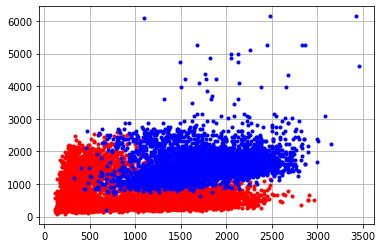

In [4]:
visualizePixels()

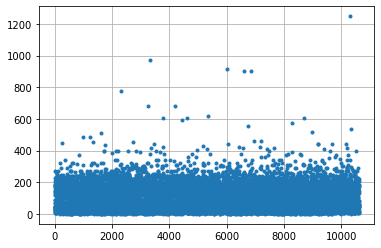

In [5]:
N_tiles_array = N_tiles()

plt.plot(list(range(len(N_tiles_array))), N_tiles_array, '.')
plt.grid()
plt.show()

((12032, 28672), (3008, 7168), (752, 1792))
['radboud' '3' '4+3']
[0.04583498896384726, 0.010562234995316486, 0.00039836338588169644, 0.0, 0.0] [0.23044043936931108, 0.00869125083014439, 0.0, 0.0]


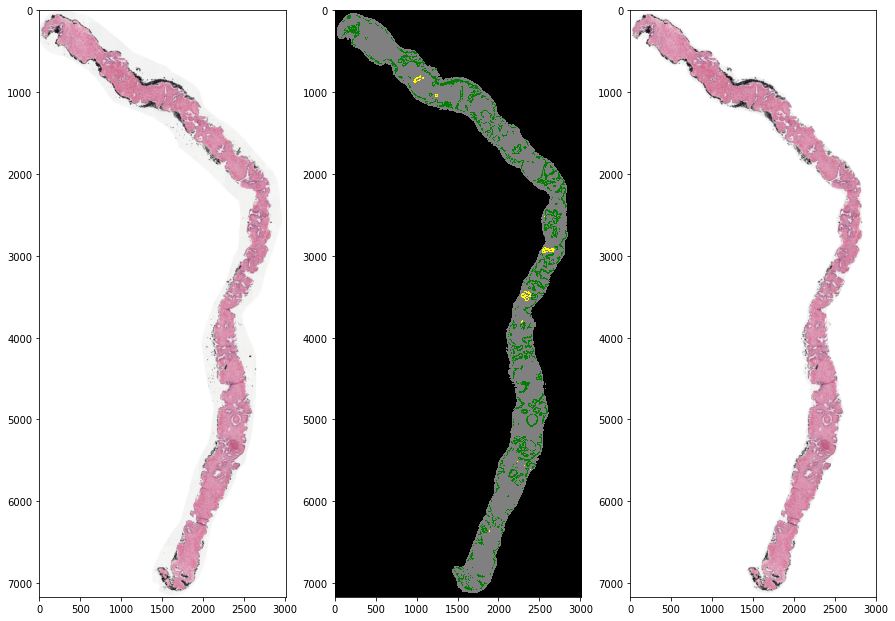

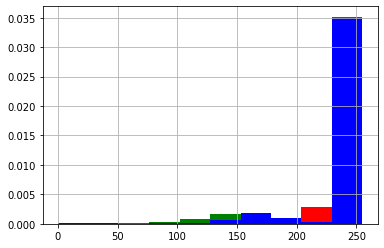

In [4]:
idx = 321
level = 1

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
im = openslide.OpenSlide(images_path + image_id[idx])

print(im.level_dimensions)
print(image_info[idx])
im2 = im.read_region(location=(0, 0), level=level, \
                      size=(im.level_dimensions[level][0],\
                            im.level_dimensions[level][1]))
data = np.asarray(im2)[:, :, 0:3]
ax[0].imshow(data)
im.close()


im = openslide.OpenSlide(masks_path + mask_id[idx])
im2 = im.read_region(location=(0, 0), level=level, \
                      size=(im.level_dimensions[level][0],\
                            im.level_dimensions[level][1]))
im.close()
mask_data = np.asarray(im2)[:, :, 0:3]

score, relative_score = grade(mask_data)
print(score, relative_score)

if image_info[idx][0] == 'karolinska':
    ax[1].imshow(mask_data[:, :, 0], cmap=cmap2, vmin=0, vmax=2, interpolation='nearest')
else:
    ax[1].imshow(mask_data[:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
    
    
clean_data = np.array(data)
clean_data[np.where((mask_data == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
ax[2].imshow(clean_data)


plt.show()

hist_data = np.concatenate((clean_data[:, :, 0].flatten(), clean_data[:, :, 1].flatten(), clean_data[:, :, 2].flatten()))
plt.hist(clean_data[:, :, 0].flatten(), density=True, color='red')
plt.hist(clean_data[:, :, 1].flatten(), density=True, color='green')
plt.hist(clean_data[:, :, 2].flatten(), density=True, color='blue')
plt.grid()
plt.show()

# tiles: 1288


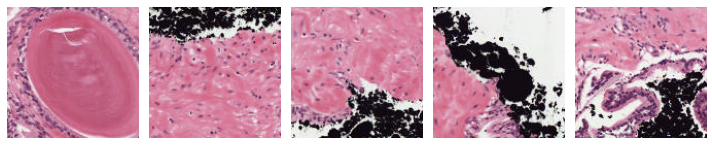

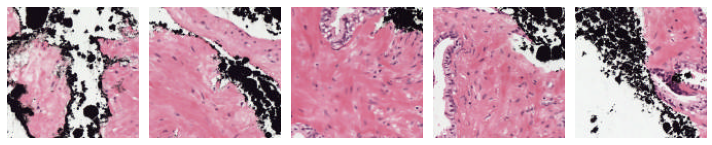

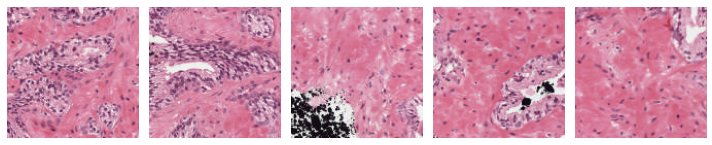

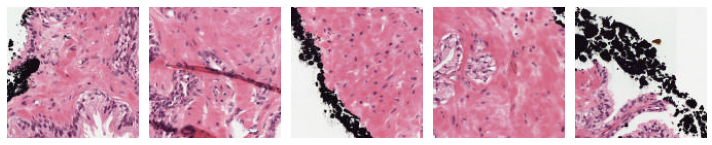

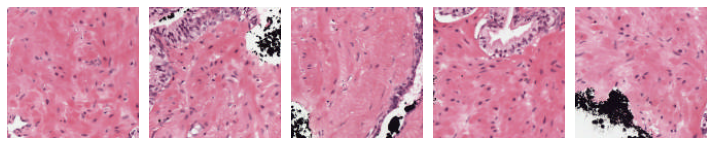

# tiles: 1288


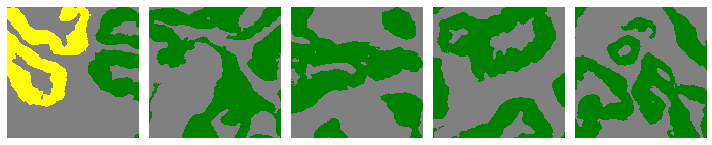

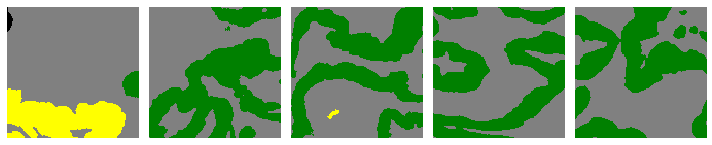

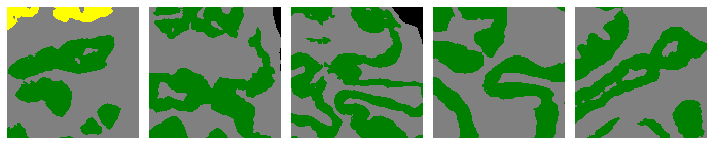

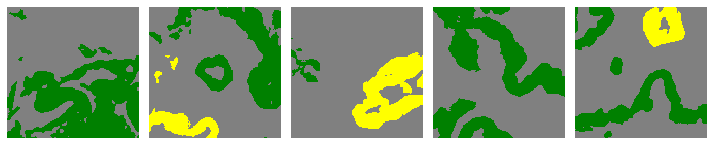

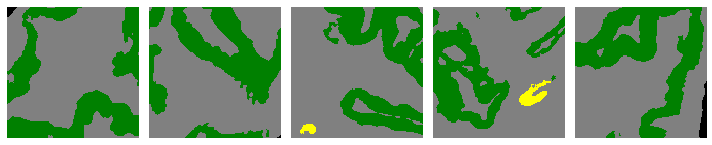

In [5]:
# visualizeTiles(clean_data, 128)
visualizeTiles(data, 128)
visualizeTiles(mask_data, 128, ifMask=True)
# visualizeOverlay(clean_data, mask_data)

In [6]:
tiles1 = tile2(clean_data, 128)
tiles2 = tile2(mask_data, 128)
tiles2 = {k: v for k, v in sorted(tiles2.items(), key=lambda item: item[1].sum(), reverse=True)}
print(tiles2.keys())

dict_keys([639, 960, 388, 753, 480, 526, 98, 457, 984, 870, 549, 754, 99, 893, 1029, 24, 616, 145, 594, 193, 571, 617, 983, 1141, 412, 316, 365, 1007, 147, 892, 458, 776, 387, 1254, 869, 196, 1028, 572, 174, 389, 823, 197, 504, 243, 961, 339, 267, 707, 146, 503, 194, 364, 244, 937, 915, 435, 799, 1142, 268, 25, 1119, 173, 777, 315, 171, 121, 291, 245, 48, 1255, 684, 341, 47, 123, 170, 731, 269, 1005, 481, 219, 891, 730, 220, 822, 221, 1006, 195, 122, 846, 97, 916, 527, 1231, 26, 172, 192, 938, 708, 661, 1232, 96, 317, 1233, 1186, 198, 868, 168, 982, 1209, 1074, 1052, 293, 1164, 1118, 340, 144, 1097, 50, 914, 49, 824, 292, 1187, 1050, 662, 169, 1096, 72, 73, 800, 1051, 1210, 95, 363, 847, 1073, 74, 685, 845, 593, 962, 1163, 120, 548, 218, 1027, 149, 939, 638, 1256, 1230, 71, 550, 1165, 411, 640, 801, 729, 434, 1, 706, 752, 217, 342, 338, 23, 1277, 46, 1188, 148, 1004, 27, 1278, 2, 1095, 1075, 150, 595, 270, 1208, 1253, 959, 985, 222, 775, 75, 124, 1211, 51, 1030, 1120, 798, 1140, 366, 2

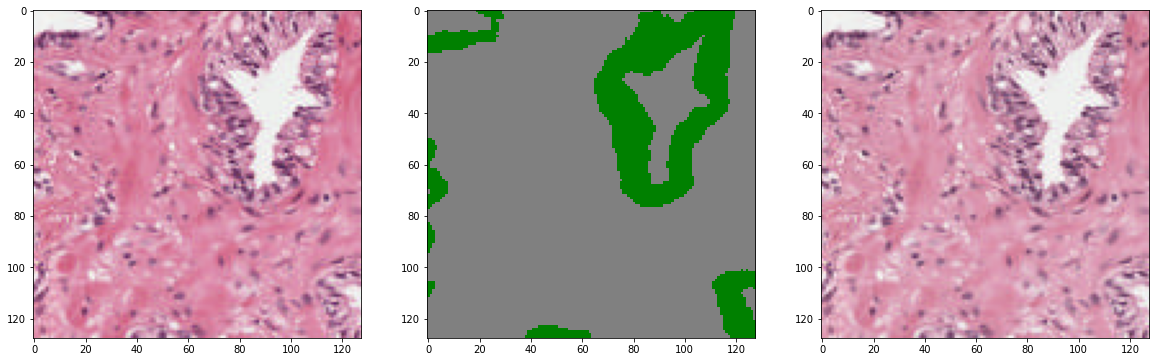

[0.8173828125, 0.1826171875, 0.0, 0.0, 0.0]
[0.22341696535244923, 0.0, 0.0, 0.0]
1.0
0.0
1


In [10]:
fig, ax = plt.subplots(1,  3, figsize=(20, 20))

tile_idx = 268
test = np.array(tiles2[tile_idx])
ax[0].imshow(tiles1[tile_idx])
ax[1].imshow(test[:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
ax[2].imshow(tf.image.random_saturation(tiles1[tile_idx], 0.6, 1.4))
plt.show()

score, relative_score = grade(test)

print(score)
print(relative_score)
print(np.sum(score))
print(np.sort(relative_score)[:3].sum())

tile_score = -1
if np.sum(score) == 1:
    if np.sort(relative_score)[:3].sum() == 0:
        if score[np.argmax(relative_score) + 1] > 0.4:
            tile_score = np.argmax(relative_score) + 2
        elif score[0] > 0.7:
            tile_score = 1
print(tile_score)

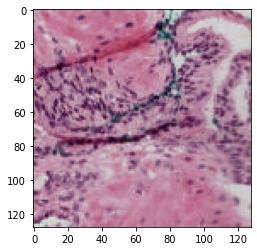

In [17]:
def customAugmentation(img):
    r = np.random.randint(low=1, high=7)
    if r == 1:
        temp = tf.image.rot90(img, k=np.random.randint(low=1, high=4))
    elif r == 2:
        temp = tf.image.random_brightness(img, max_delta=0.2)
    elif r == 3:
        temp = tf.image.random_hue(img, max_delta=0.2)
    elif r == 4:
        temp = tf.image.random_flip_left_right(img)
    elif r == 5:
        temp = tf.image.random_flip_up_down(img)
    elif r == 6:
        temp = tf.image.random_saturation(img, 0.6, 1.4)
    
    return temp

temp = tiles1[tile_idx]
for j in range(np.random.randint(low=2, high=6)):
    temp = customAugmentation(temp)
plt.imshow(temp)

In [13]:
# train_image_id, train_mask_id, train_image_info, test_image_id, test_mask_id, test_image_info = split_into_traintest()

# temp1 = np.concatenate((train_image_id, train_mask_id, train_image_info), axis=1)
# temp2 = np.concatenate((test_image_id, test_mask_id, test_image_info), axis=1)
# print(len(temp1), len(temp2))
# np.savetxt("./prostate-cancer-grade-assessment/new_train.csv", temp1, delimiter=",", fmt="%s")
# np.savetxt("./prostate-cancer-grade-assessment/new_test.csv", temp2, delimiter=",", fmt="%s")

In [15]:
# new_train = np.genfromtxt("./prostate-cancer-grade-assessment/new_train.csv", delimiter=",", dtype='str')
# suspicious_train = np.genfromtxt("./prostate-cancer-grade-assessment/suspicious_train.csv", delimiter=",", dtype='str')
# print(new_train[0])
# print(suspicious_train[0])

# temp = []
# for idx1 in trange(len(new_train)):
#     check = 0
#     for idx2 in range(len(suspicious_train)):
#         if suspicious_train[idx2] in new_train[idx1][0]:
#             check = 1
#             break
#     if check == 0:
#         temp.append(new_train[idx1])
        
# print(len(new_train), len(temp))
# np.savetxt("./prostate-cancer-grade-assessment/temp.csv", temp, delimiter=",", fmt="%s")

['0018ae58b01bdadc8e347995b69f99aa.tiff'
 '0018ae58b01bdadc8e347995b69f99aa_mask.tiff' 'radboud' '4' '4+4']
184a184ac82d72d499f99b67d6a1c631



4699 4225


In [4]:
# train = np.genfromtxt("./prostate-cancer-grade-assessment/train.csv", delimiter=",", dtype='str', skip_header=1)
# kaggle_remove_ka = np.genfromtxt("./prostate-cancer-grade-assessment/kaggle_remove_ka.csv", delimiter=",", dtype='str', skip_header=1)
# kaggle_remove_ka = kaggle_remove_ka[(kaggle_remove_ka != ['', '', '', '', '', '', '', '', '', '']).all(axis=1)]
# temp = []
# for idx1 in trange(len(kaggle_remove_ka)):
#     row = []
#     for idx2 in range(len(train)):
#         if kaggle_remove_ka[idx1][1] in train[idx2]:
#             temp.append([image_id[idx2], mask_id[idx2], train[idx2][1], train[idx2][2], train[idx2][3]])
# np.savetxt("./prostate-cancer-grade-assessment/new_test_kaggle_remove_ka.csv", temp, delimiter=",", fmt="%s")

  0%|          | 0/5121 [00:00<?, ?it/s]

In [10]:
# '''
# Extract patches and save filenames into a csv
# '''
# create_patches(train_image_id, train_mask_id, sz=128, ifSharp=False)

  0%|          | 0/3725 [00:00<?, ?it/s]

In [4]:
"""
Reconstruct model
"""
def reconstruct_model(checkpoint_filepath, ifMC):
    denseNet = applications.DenseNet201(include_top=False, weights=None, input_shape=(128, 128, 3),  pooling='avg')

    output = denseNet.output
    output = layers.Dropout(0.5)(output)
    if ifMC == 0:
        output = layers.Dense(2, activation='softmax')(output)
    elif ifMC == 1:
        output = layers.Dense(5, activation='softmax')(output)

    model = tf.keras.models.Model(denseNet.input, output)

    opt = tf.keras.optimizers.SGD(learning_rate=0.0002, momentum=0.7)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=opt,
                 loss=loss,
                 metrics=['accuracy','AUC'])
    model.load_weights(checkpoint_filepath)
    return model

"""
Model 1v setup
"""
print("Setting up model 1v")
checkpoint_filepath_1v = "./model_result/2021_01_21_22_44_16/checkpoint/"
# checkpoint_filepath_1v = "./model_result/2021_03_23_22_21_32/checkpoint/"
model_1v = reconstruct_model(checkpoint_filepath_1v, 0)

"""
Model 2v setup
"""
print("Setting up model 2v")
checkpoint_filepath_2v = "./model_result/2021_01_22_22_08_24/checkpoint/"
# checkpoint_filepath_2v = "./model_result/2021_03_24_20_58_22/checkpoint/"
model_2v = reconstruct_model(checkpoint_filepath_2v, 0)

"""
Model 3v setup
"""
print("Setting up model 3v")
checkpoint_filepath_3v = "./model_result/2021_01_23_18_59_44/checkpoint/"
# checkpoint_filepath_3v = "./model_result/2021_03_25_21_10_05/checkpoint/"
model_3v = reconstruct_model(checkpoint_filepath_3v, 0)

"""
Model 4v setup
"""
print("Setting up model 4v")
checkpoint_filepath_4v = "./model_result/2021_02_12_22_24_50/checkpoint/"
# checkpoint_filepath_4v = "./model_result/2021_03_26_21_11_33/checkpoint/"
model_4v = reconstruct_model(checkpoint_filepath_4v, 0)

"""
Model Multi-Class setup
"""
print("Setting up model MC")
checkpoint_filepath_MC = "./model_result/2021_02_14_21_02_23/checkpoint/"
# checkpoint_filepath_MC = "./model_result/2021_03_22_23_04_31/checkpoint/"
model_MC = reconstruct_model(checkpoint_filepath_MC, 1)

"""
DT inference
"""
def DT(x_test):
    temp = model_1v.predict(x_test)
    yhat_DT = np.argmax(temp, axis=1)
    yhat_DT_magnitude = np.max(temp, axis=1)
    
    if (yhat_DT == 1).sum() > 0:
        temp = model_2v.predict(x_test[yhat_DT == 1])
        yhat_temp = np.argmax(temp, axis=1)
        count = 0
        for idx in range(len(yhat_DT)):
            if yhat_DT[idx] == 1:
                if yhat_temp[count] == 0:
                    yhat_DT[idx] = 1
                else:
                    yhat_DT[idx] = 2
                yhat_DT_magnitude[idx] = np.max(temp, axis=1)[count]
                count += 1

    if (yhat_DT == 2).sum() > 0:
        temp = model_3v.predict(x_test[yhat_DT == 2])
        yhat_temp = np.argmax(temp, axis=1)
        count = 0
        for idx in range(len(yhat_DT)):
            if yhat_DT[idx] == 2:
                if yhat_temp[count] == 0:
                    yhat_DT[idx] = 2
                else:
                    yhat_DT[idx] = 3
                yhat_DT_magnitude[idx] = np.max(temp, axis=1)[count]
                count += 1
    
    if (yhat_DT == 3).sum() > 0:
        temp = model_4v.predict(x_test[yhat_DT == 3])
        yhat_temp = np.argmax(temp, axis=1)
        count = 0
        for idx in range(len(yhat_DT)):
            if yhat_DT[idx] == 3:
                if yhat_temp[count] == 0:
                    yhat_DT[idx] = 3
                else:
                    yhat_DT[idx] = 4
                yhat_DT_magnitude[idx] = np.max(temp, axis=1)[count]
                count += 1
                
    return yhat_DT, yhat_DT_magnitude

"""
MC inference
"""
def MC(x_test):
    temp = model_MC.predict(x_test)
    yhat_MC = np.argmax(temp, axis=1)
    yhat_MC_magnitue = np.max(temp, axis=1)
    return yhat_MC, yhat_MC_magnitue

Setting up model 1v
Setting up model 2v
Setting up model 3v
Setting up model 4v
Setting up model MC


['00951a7fad040bf7e90f32e81fc0746f.tiff'
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff' 'radboud' '1' '3+3']


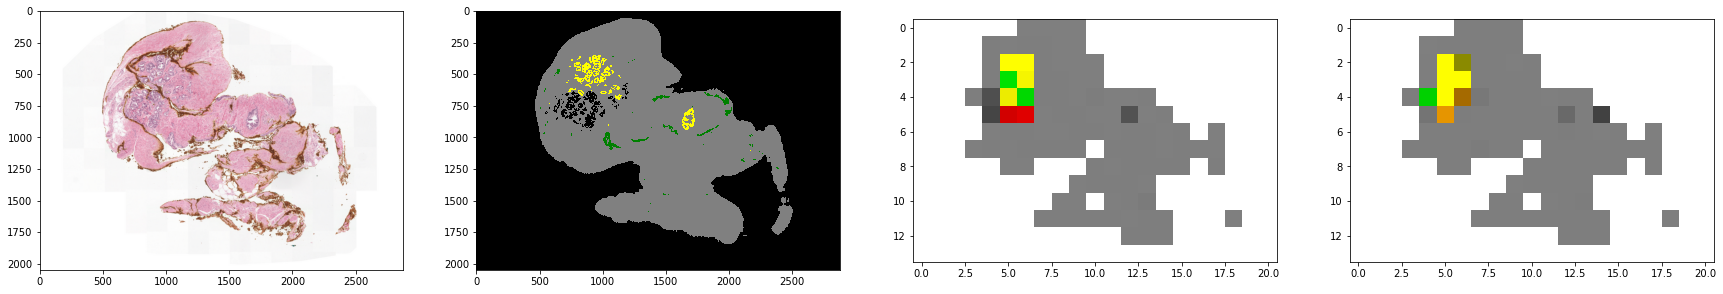

--- 5.851465463638306 seconds ---


In [8]:
"""
Display predicted mask data
"""
start_time = time.time()

new_train_info_path = "./prostate-cancer-grade-assessment/new_train.csv"
images_path = "./prostate-cancer-grade-assessment/train_images/"
masks_path = "./prostate-cancer-grade-assessment/train_label_masks/"

train_image_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=0)
train_image_mask_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=1)
train_image_fullInfo = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=(0, 1, 2, 3, 4))
test_slideFolders = np.genfromtxt("./prostate-cancer-grade-assessment/temp_test_slideFolders.csv", delimiter=",", dtype='str', usecols=0)
train_slideFolders = np.genfromtxt("./prostate-cancer-grade-assessment/temp_train_slideFolders.csv", delimiter=",", dtype='str', usecols=0)
validation_slideFolders = np.genfromtxt("./prostate-cancer-grade-assessment/temp_validation_slideFolders.csv", delimiter=",", dtype='str', usecols=0)

level = 1
sz = 128
tile_size = 128
overlap = int((sz - tile_size) / 2)
x_list_DT = []
y_list_DT = []
x_list_MC = []
y_list_MC = []
# for train_slideFolders_idx in trange(len(train_slideFolders)):
# for validation_slideFolders_idx in range(36, 37):
# for test_slideFolders_idx in trange(len(test_slideFolders)):
for test_slideFolders_idx in range(300, 80):
    for new_train_idx in range(len(train_image_id)):
#         if train_slideFolders[train_slideFolders_idx] in train_image_id[new_train_idx]:
#         if validation_slideFolders[validation_slideFolders_idx] in train_image_id[new_train_idx]:
        if test_slideFolders[test_slideFolders_idx] in train_image_id[new_train_idx]:
#         if test_slideFolders[y_test != "negative"][test_slideFolders_idx] in train_image_id[new_train_idx]:
            print(train_image_fullInfo[new_train_idx])
            fig, ax = plt.subplots(1, 4, figsize=(30, 30))
            
            # H&E
            im = openslide.OpenSlide(images_path + train_image_id[new_train_idx])
            im2 = im.read_region(location=(0, 0), level=level, \
                              size=(im.level_dimensions[level][0],\
                                    im.level_dimensions[level][1]))

            width = im.level_dimensions[level][0]
            height = im.level_dimensions[level][1]

            data = np.array(im2)[:, :, 0:3]
            ax[0].imshow(data)
            
            # Select tiles
            dpz = deepzoom.DeepZoomGenerator(im, tile_size=tile_size, overlap=overlap, limit_bounds=True)
            width = dpz.level_tiles[dpz.level_count - 3][0]
            height = dpz.level_tiles[dpz.level_count - 3][1]
            offset = int(np.ceil(overlap / tile_size)) + 1

            tiles1 = []
            for j in range(offset, dpz.level_tiles[dpz.level_count - 3][1] - offset):
                for i in range(offset, dpz.level_tiles[dpz.level_count - 3][0] - offset):
                    tiles1.append(np.asarray(dpz.get_tile(dpz.level_count - 3, (i, j))))
            tiles1 = np.stack(tiles1, axis=0)
            
            im.close()

            temp_idx_list = []
            for p in tiles1:
                if p.sum() < (12533760 * 0.85):
                    temp_idx_list.append(True)
                else:
                    temp_idx_list.append(False)

            # DT
            predicted_mask_data_DT = [[255, 255, 255]] * len(temp_idx_list)
            temp_predicted_mask_data_DT, temp_predicted_mask_data_DT_magnitude = DT(tiles1[temp_idx_list] / 255.0)
            temp_predicted_mask_data_DT += 1
            count = 0
            for temp_idx in range(len(predicted_mask_data_DT)):
                if temp_idx_list[temp_idx] == True:
                    if temp_predicted_mask_data_DT[count] == 1:
                        predicted_mask_data_DT[temp_idx] = (np.array([127, 127, 127]) * temp_predicted_mask_data_DT_magnitude[count])
                    elif temp_predicted_mask_data_DT[count] == 2:
                        predicted_mask_data_DT[temp_idx] = (np.array([0, 255, 0]) * temp_predicted_mask_data_DT_magnitude[count])
                    elif temp_predicted_mask_data_DT[count] == 3:
                        predicted_mask_data_DT[temp_idx] = (np.array([255, 255, 0]) * temp_predicted_mask_data_DT_magnitude[count])
                    elif temp_predicted_mask_data_DT[count] == 4:
                        predicted_mask_data_DT[temp_idx] = (np.array([255, 165, 0]) * temp_predicted_mask_data_DT_magnitude[count])
                    elif temp_predicted_mask_data_DT[count] == 5:
                        predicted_mask_data_DT[temp_idx] = (np.array([255, 0, 0]) * temp_predicted_mask_data_DT_magnitude[count])
                    count += 1

            predicted_mask_data_DT = np.array(predicted_mask_data_DT).reshape(height - 2 * offset, width - 2 * offset, 3).astype(np.uint8)
#             predicted_mask_data_DT = np.array(predicted_mask_data_DT).reshape(int(height / 128), int(width / 128), 3).astype(np.uint8)
#             predicted_mask_data_DT = cv2.resize(predicted_mask_data_DT, (int(width / 128) * 128, int(height / 128) * 128), interpolation = cv2.INTER_NEAREST)
            ax[2].imshow(predicted_mask_data_DT)

            # MC
            predicted_mask_data_MC = [[255, 255, 255]] * len(temp_idx_list)
            temp_predicted_mask_data_MC, temp_predicted_mask_data_MC_magnitude = MC(tiles1[temp_idx_list] / 255.0)
            temp_predicted_mask_data_MC += 1
            count = 0
            for temp_idx in range(len(predicted_mask_data_MC)):
                if temp_idx_list[temp_idx] == True:
                    if temp_predicted_mask_data_MC[count] == 1:
                        predicted_mask_data_MC[temp_idx] = (np.array([127, 127, 127]) * temp_predicted_mask_data_MC_magnitude[count])
                    elif temp_predicted_mask_data_MC[count] == 2:
                        predicted_mask_data_MC[temp_idx] = (np.array([0, 255, 0]) * temp_predicted_mask_data_MC_magnitude[count])
                    elif temp_predicted_mask_data_MC[count] == 3:
                        predicted_mask_data_MC[temp_idx] = (np.array([255, 255, 0]) * temp_predicted_mask_data_MC_magnitude[count])
                    elif temp_predicted_mask_data_MC[count] == 4:
                        predicted_mask_data_MC[temp_idx] = (np.array([255, 165, 0]) * temp_predicted_mask_data_MC_magnitude[count])
                    elif temp_predicted_mask_data_MC[count] == 5:
                        predicted_mask_data_MC[temp_idx] = (np.array([255, 0, 0]) * temp_predicted_mask_data_MC_magnitude[count])
                    count += 1
                    
            predicted_mask_data_MC = np.array(predicted_mask_data_MC).reshape(height - 2 * offset, width - 2 * offset, 3).astype(np.uint8)
#             predicted_mask_data_MC = np.array(predicted_mask_data_MC).reshape(int(height / 128), int(width / 128), 3).astype(np.uint8)
#             predicted_mask_data_MC = cv2.resize(predicted_mask_data_MC, (int(width / 128) * 128, int(height / 128) * 128), interpolation = cv2.INTER_NEAREST)
            ax[3].imshow(predicted_mask_data_MC)
            
            # Mask
            im = openslide.OpenSlide(masks_path + train_image_mask_id[new_train_idx])
            im2 = im.read_region(location=(0, 0), level=level, \
                              size=(im.level_dimensions[level][0],\
                                    im.level_dimensions[level][1]))
            im.close()

            mask_data = np.array(im2)[:, :, 0:3]
            if train_image_fullInfo[new_train_idx][0] == 'karolinska':
                ax[1].imshow(mask_data[:, :, 0], cmap=cmap2, vmin=0, vmax=2, interpolation='nearest')
            else:
                ax[1].imshow(mask_data[:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')

            plt.show()
            break

print("--- %s seconds ---" % (time.time() - start_time))

In [77]:
# """
# Save slidefolders classification result
# """

# new_train_info_path = "./prostate-cancer-grade-assessment/new_train.csv"
# images_path = "./prostate-cancer-grade-assessment/train_images/"
# masks_path = "./prostate-cancer-grade-assessment/train_label_masks/"

# train_image_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=0)
# train_image_mask_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=1)
# train_image_fullInfo = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=(0, 1, 2, 3, 4))
# test_slideFolders = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders.csv", delimiter=",", dtype='str', usecols=0)
# train_slideFolders = np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders.csv", delimiter=",", dtype='str', usecols=0)
# validation_slideFolders = np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders.csv", delimiter=",", dtype='str', usecols=0)

# def tile(data, sz):
#     tiles = []
#     for row_idx in range(len(data) // sz):
#         for col_idx in range(len(data[0]) // sz):
#             tiles.append(data[row_idx*sz:(row_idx*sz+sz)][:, col_idx*sz:(col_idx*sz + sz)])
#     return tiles

# level = 1
# sz = 128
# tile_size = 16
# overlap = int((sz - tile_size) / 2)
# x_list_DT = []
# y_list_DT = []
# x_list_MC = []
# y_list_MC = []
# # for train_slideFolders_idx in trange(len(train_slideFolders)):
# # for validation_slideFolders_idx in trange(len(validation_slideFolders)):
# for test_slideFolders_idx in trange(len(test_slideFolders)):
# # for test_slideFolders_idx in range(0, 1):
#     for new_train_idx in range(len(train_image_id)):
# #         if train_slideFolders[train_slideFolders_idx] in train_image_id[new_train_idx]:
# #         if validation_slideFolders[validation_slideFolders_idx] in train_image_id[new_train_idx]:
#         if test_slideFolders[test_slideFolders_idx] in train_image_id[new_train_idx]:
#             # H&E
#             im = openslide.OpenSlide(images_path + train_image_id[new_train_idx])
            
#             # Select tiles
#             dpz = deepzoom.DeepZoomGenerator(im, tile_size=tile_size, overlap=overlap, limit_bounds=False)
#             width = dpz.level_tiles[dpz.level_count - 3][0]
#             height = dpz.level_tiles[dpz.level_count - 3][1]
#             offset = int(np.ceil(overlap / tile_size))

#             tiles1 = []
#             for j in range(offset, dpz.level_tiles[dpz.level_count - 3][1] - offset):
#                 for i in range(offset, dpz.level_tiles[dpz.level_count - 3][0] - offset):
#                     tiles1.append(np.asarray(dpz.get_tile(dpz.level_count - 3, (i, j))))
#             tiles1 = np.stack(tiles1, axis=0)
            
#             im.close()
            
#             temp_idx_list = []
#             for p in tiles1:
#                 if p.sum() < (12533760 * 0.9):
#                     temp_idx_list.append(True)
#                 else:
#                     temp_idx_list.append(False)
            
#             # DT
#             predicted_mask_data_DT = [0] * len(temp_idx_list)
#             temp_predicted_mask_data_DT, temp_predicted_mask_data_DT_magnitude = DT(tiles1[temp_idx_list] / 255.0)
#             temp_predicted_mask_data_DT += 1
#             count = 0
#             for temp_idx in range(len(predicted_mask_data_DT)):
#                 if temp_idx_list[temp_idx] == True:
#                     predicted_mask_data_DT[temp_idx] = temp_predicted_mask_data_DT[count]
#                     count += 1
            
#             # MC
#             predicted_mask_data_MC = [0] * len(temp_idx_list)
#             temp_predicted_mask_data_MC, temp_predicted_mask_data_MC_magnitude = MC(tiles1[temp_idx_list] / 255.0)
#             temp_predicted_mask_data_MC += 1
#             count = 0
#             for temp_idx in range(len(predicted_mask_data_MC)):
#                 if temp_idx_list[temp_idx] == True:
#                     predicted_mask_data_MC[temp_idx] = temp_predicted_mask_data_MC[count]
#                     count += 1
            
#             # Extract DT features
#             temp1 = 0
#             temp2 = 0
#             temp3 = 0
#             temp4 = 0
#             temp5 = 0
#             count = 0
#             for i in predicted_mask_data_DT:
#                 if i == 1:
#                     temp1 += temp_predicted_mask_data_DT_magnitude[count]
#                 elif i == 2:
#                     temp2 += temp_predicted_mask_data_DT_magnitude[count]
#                 elif i == 3:
#                     temp3 += temp_predicted_mask_data_DT_magnitude[count]
#                 elif i == 4:
#                     temp4 += temp_predicted_mask_data_DT_magnitude[count]
#                 elif i == 5:
#                     temp5 += temp_predicted_mask_data_DT_magnitude[count]
                
#                 if i != 0:
#                     count += 1
            
#             if np.equal(predicted_mask_data_DT, 1).sum() > 0:
#                 temp1 = temp1 / np.equal(predicted_mask_data_DT, 1).sum()
#             if np.equal(predicted_mask_data_DT, 2).sum() > 0:
#                 temp2 = temp2 / np.equal(predicted_mask_data_DT, 2).sum()
#             if np.equal(predicted_mask_data_DT, 3).sum() > 0:
#                 temp3 = temp3 / np.equal(predicted_mask_data_DT, 3).sum()
#             if np.equal(predicted_mask_data_DT, 4).sum() > 0:
#                 temp4 = temp4 / np.equal(predicted_mask_data_DT, 4).sum()
#             if np.equal(predicted_mask_data_DT, 5).sum() > 0:
#                 temp5 = temp5 / np.equal(predicted_mask_data_DT, 5).sum()
            
#             unique_DT = np.unique(predicted_mask_data_DT, return_counts=True)
#             length = len(predicted_mask_data_DT)
#             temp_list_DT = [0, 0, 0, 0, 0, 0, temp1, temp2, temp3, temp4, temp5]
#             for temp_idx in range(len(unique_DT[0])):
#                 if int(unique_DT[0][temp_idx]) == 0:
#                     temp_list_DT[0] = unique_DT[1][temp_idx] / length
#                 if int(unique_DT[0][temp_idx]) == 1:
#                     temp_list_DT[1] = unique_DT[1][temp_idx] / length
#                 if int(unique_DT[0][temp_idx]) == 2:
#                     temp_list_DT[2] = unique_DT[1][temp_idx] / length
#                 if int(unique_DT[0][temp_idx]) == 3:
#                     temp_list_DT[3] = unique_DT[1][temp_idx] / length
#                 if int(unique_DT[0][temp_idx]) == 4:
#                     temp_list_DT[4] = unique_DT[1][temp_idx] / length
#                 if int(unique_DT[0][temp_idx]) == 5:
#                     temp_list_DT[5] = unique_DT[1][temp_idx] / length
            
#             x_list_DT.append(temp_list_DT)
#             y_list_DT.append(int(train_image_fullInfo[new_train_idx][3]))
            
#             # Extract MC features
#             temp1 = 0
#             temp2 = 0
#             temp3 = 0
#             temp4 = 0
#             temp5 = 0
#             count = 0
#             for i in predicted_mask_data_MC:
#                 if i == 1:
#                     temp1 += temp_predicted_mask_data_MC_magnitude[count]
#                 elif i == 2:
#                     temp2 += temp_predicted_mask_data_MC_magnitude[count]
#                 elif i == 3:
#                     temp3 += temp_predicted_mask_data_MC_magnitude[count]
#                 elif i == 4:
#                     temp4 += temp_predicted_mask_data_MC_magnitude[count]
#                 elif i == 5:
#                     temp5 += temp_predicted_mask_data_MC_magnitude[count]
                
#                 if i != 0:
#                     count += 1
            
#             if np.equal(predicted_mask_data_MC, 1).sum() > 0:
#                 temp1 = temp1 / np.equal(predicted_mask_data_MC, 1).sum()
#             if np.equal(predicted_mask_data_MC, 2).sum() > 0:
#                 temp2 = temp2 / np.equal(predicted_mask_data_MC, 2).sum()
#             if np.equal(predicted_mask_data_MC, 3).sum() > 0:
#                 temp3 = temp3 / np.equal(predicted_mask_data_MC, 3).sum()
#             if np.equal(predicted_mask_data_MC, 4).sum() > 0:
#                 temp4 = temp4 / np.equal(predicted_mask_data_MC, 4).sum()
#             if np.equal(predicted_mask_data_MC, 5).sum() > 0:
#                 temp5 = temp5 / np.equal(predicted_mask_data_MC, 5).sum()
            
#             unique_MC = np.unique(predicted_mask_data_MC, return_counts=True)
#             length = len(predicted_mask_data_MC)
#             temp_list_MC = [0, 0, 0, 0, 0, 0, temp1, temp2, temp3, temp4, temp5]
#             for temp_idx in range(len(unique_MC[0])):
#                 if int(unique_MC[0][temp_idx]) == 0:
#                     temp_list_MC[0] = unique_MC[1][temp_idx] / length
#                 if int(unique_MC[0][temp_idx]) == 1:
#                     temp_list_MC[1] = unique_MC[1][temp_idx] / length
#                 if int(unique_MC[0][temp_idx]) == 2:
#                     temp_list_MC[2] = unique_MC[1][temp_idx] / length
#                 if int(unique_MC[0][temp_idx]) == 3:
#                     temp_list_MC[3] = unique_MC[1][temp_idx] / length
#                 if int(unique_MC[0][temp_idx]) == 4:
#                     temp_list_MC[4] = unique_MC[1][temp_idx] / length
#                 if int(unique_MC[0][temp_idx]) == 5:
#                     temp_list_MC[5] = unique_MC[1][temp_idx] / length
            
#             x_list_MC.append(temp_list_MC)
#             y_list_MC.append(train_image_fullInfo[new_train_idx][4])
            
#             break
            
# x_list_DT = np.array(x_list_DT)
# y_list_DT = np.array(y_list_DT)
# x_list_MC = np.array(x_list_MC)
# y_list_MC = np.array(y_list_MC)

# # Save train slidefolders classification
# train_slideFolders_classification = np.concatenate((x_list_DT, x_list_MC, y_list_DT.reshape(len(y_list_DT), 1)), axis=1)
# np.savetxt("./prostate-cancer-grade-assessment/train_slideFolders_classification.csv", train_slideFolders_classification, delimiter=",")

# # Save validation slidefolders classification
# validation_slideFolders_classification = np.concatenate((x_list_DT, x_list_MC, y_list_DT.reshape(len(y_list_DT), 1)), axis=1)
# np.savetxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification.csv", validation_slideFolders_classification, delimiter=",")

# # Save test slidefolders classification
# test_slideFolders_classification = np.concatenate((x_list_DT, x_list_MC, y_list_DT.reshape(len(y_list_DT), 1)), axis=1)
# np.savetxt("./prostate-cancer-grade-assessment/test_slideFolders_classification.csv", test_slideFolders_classification, delimiter=",")

In [53]:
# # row_length = len(np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification.csv", delimiter=",", usecols=1))
# row_length = len(np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification.csv", delimiter=",", usecols=1))
# # row_length = len(np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification.csv", delimiter=",", usecols=1))

# # f = open("./prostate-cancer-grade-assessment/train_slideFolders_classification2_threshold_0.csv", "a+", newline="")
# f = open("./prostate-cancer-grade-assessment/validation_slideFolders_classification2_threshold_0.csv", "a+", newline="")
# # f = open("./prostate-cancer-grade-assessment/test_slideFolders_classification2_threshold_9.csv", "a+", newline="")
# wr = csv.writer(f)

# for i in trange(row_length):
# #     slideFolders_classification = np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification.csv", delimiter=",", skip_header=i, max_rows=1, dtype=np.str)
#     slideFolders_classification = np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification.csv", delimiter=",", skip_header=i, max_rows=1, dtype=np.str)
# #     slideFolders_classification = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification.csv", delimiter=",", skip_header=i, max_rows=1, dtype=np.str)

#     DT_data = slideFolders_classification[:int((len(slideFolders_classification) - 1)/2/2)].astype(float)
#     DT_magnitude = slideFolders_classification[int((len(slideFolders_classification) - 1)/2/2):int((len(slideFolders_classification) - 1)/2)].astype(float)
#     MC_data = slideFolders_classification[int((len(slideFolders_classification) - 1)/2):int((len(slideFolders_classification) - 1)/2 + (len(slideFolders_classification) - 1)/2/2)].astype(float)
#     MC_magnitude = slideFolders_classification[int((len(slideFolders_classification) - 1)/2 + (len(slideFolders_classification) - 1)/2/2):len(slideFolders_classification)-1].astype(float)
#     y = [slideFolders_classification[-1].tolist()]

#     DT_data = DT_data[DT_magnitude > 0]
#     MC_data = MC_data[MC_magnitude > 0]

#     unique_DT = np.unique(DT_data, return_counts=True)
#     temp_list_DT = [0, 0, 0, 0, 0]
#     for temp_idx in range(len(unique_DT[0])):
#         if int(unique_DT[0][temp_idx]) == 1:
#             temp_list_DT[0] = unique_DT[1][temp_idx]
#         if int(unique_DT[0][temp_idx]) == 2:
#             temp_list_DT[1] = unique_DT[1][temp_idx]
#         if int(unique_DT[0][temp_idx]) == 3:
#             temp_list_DT[2] = unique_DT[1][temp_idx]
#         if int(unique_DT[0][temp_idx]) == 4:
#             temp_list_DT[3] = unique_DT[1][temp_idx]
#         if int(unique_DT[0][temp_idx]) == 5:
#             temp_list_DT[4] = unique_DT[1][temp_idx]

#     unique_MC = np.unique(MC_data, return_counts=True)
#     temp_list_MC = [0, 0, 0, 0, 0]
#     for temp_idx in range(len(unique_MC[0])):
#         if int(unique_MC[0][temp_idx]) == 1:
#             temp_list_MC[0] = unique_MC[1][temp_idx]
#         if int(unique_MC[0][temp_idx]) == 2:
#             temp_list_MC[1] = unique_MC[1][temp_idx]
#         if int(unique_MC[0][temp_idx]) == 3:
#             temp_list_MC[2] = unique_MC[1][temp_idx]
#         if int(unique_MC[0][temp_idx]) == 4:
#             temp_list_MC[3] = unique_MC[1][temp_idx]
#         if int(unique_MC[0][temp_idx]) == 5:
#             temp_list_MC[4] = unique_MC[1][temp_idx]
            
#     wr.writerow(temp_list_DT + temp_list_MC + y)

# f.close()

  0%|          | 0/589 [00:00<?, ?it/s]

In [4]:
"""
Read in data for counting method and weighted vote method
"""
# row_length = len(np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification.csv", delimiter=",", usecols=1))
# row_length = len(np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification.csv", delimiter=",", usecols=1))
# row_length = len(np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification.csv", delimiter=",", usecols=1))
row_length = len(np.genfromtxt("./prostate-cancer-grade-assessment/kaggle_remove_ka_slideFolders_classification_tilesize_126.csv", delimiter=",", usecols=1))

DT_data = []
DT_magnitude = []
MC_data = []
MC_magnitude = []
y = []
for i in trange(row_length):
#     slideFolders_classification = np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification.csv", delimiter=",", skip_header=i, max_rows=1, dtype=np.str)
#     slideFolders_classification = np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification.csv", delimiter=",", skip_header=i, max_rows=1, dtype=np.str)
#     slideFolders_classification = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification.csv", delimiter=",", skip_header=i, max_rows=1, dtype=np.str)
    slideFolders_classification = np.genfromtxt("./prostate-cancer-grade-assessment/kaggle_remove_ka_slideFolders_classification_tilesize_126.csv", delimiter=",", skip_header=i, max_rows=1, dtype=np.str)
    slideFolders_classification = slideFolders_classification[slideFolders_classification != '']

    DT_data.append(slideFolders_classification[:int((len(slideFolders_classification) - 1)/2/2)].astype(float))
    DT_magnitude.append(slideFolders_classification[int((len(slideFolders_classification) - 1)/2/2):int((len(slideFolders_classification) - 1)/2)].astype(float))
    MC_data.append(slideFolders_classification[int((len(slideFolders_classification) - 1)/2):int((len(slideFolders_classification) - 1)/2 + (len(slideFolders_classification) - 1)/2/2)].astype(float))
    MC_magnitude.append(slideFolders_classification[int((len(slideFolders_classification) - 1)/2 + (len(slideFolders_classification) - 1)/2/2):len(slideFolders_classification)-1].astype(float))
    y.append(slideFolders_classification[-1].tolist())

  0%|          | 0/4975 [00:00<?, ?it/s]

In [9]:
'''
Predict first # using weighted vote
'''
yhat1 = []
y_test1 = []
yhat2 = []
y_test2 = []
yhat3 = []
y_test3 = []
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0
threshold = 0
for case_idx in trange(len(y)):
    temp1 = []
    for i in MC_data[case_idx]:
        if i == 1:
            temp1.append([1, 0, 0, 0, 0])
        elif i == 2:
            temp1.append([0, 1, 0, 0, 0])
        elif i == 3:
            temp1.append([0, 0, 1, 0, 0])
        elif i == 4:
            temp1.append([0, 0, 0, 1, 0])
        elif i == 5:
            temp1.append([0, 0, 0, 0, 1])
    temp1 = np.stack(temp1)

    temp11 = []
    for idx in range(len(temp1)):
        temp11.append((temp1[idx] * MC_magnitude[case_idx][idx]).tolist())
    temp11 = np.stack(temp11)

    temp111 = np.array([temp11[:, 0][temp11[:, 0] > threshold].sum(), temp11[:, 1][temp11[:, 1] > threshold].sum(), temp11[:, 2][temp11[:, 2] > threshold].sum(), temp11[:, 3][temp11[:, 3] > threshold].sum(), temp11[:, 4][temp11[:, 4] > threshold].sum()])
    temp111 = temp111 / temp111.sum()
    
    if y[case_idx] != "0+0":
        if int(y[case_idx][0]) != int(y[case_idx][2]):
            if np.argsort(-temp111[2:5])[0] + 3 == int(y[case_idx][0]):
                count1 += 1
            count2 += 1
            yhat1.append(np.argsort(-temp111[2:5])[0] + 1)
            
            if int(y[case_idx][0]) == 3:
                y_test1.append(1)
            elif int(y[case_idx][0]) == 4:
                y_test1.append(2)
            elif int(y[case_idx][0]) == 5:
                y_test1.append(3)
        else:
            if np.argsort(-temp111[2:5])[0] + 3 == int(y[case_idx][0]):
                count3 += 1
            count4 += 1
            
            yhat2.append(np.argsort(-temp111[2:5])[0] + 1)
            
            if int(y[case_idx][0]) == 3:
                y_test2.append(1)
            elif int(y[case_idx][0]) == 4:
                y_test2.append(2)
            elif int(y[case_idx][0]) == 5:
                y_test2.append(3)
        
    else:
        if np.argsort(-temp111[0:5])[0] == 0 or np.argsort(-temp111[0:5])[0] == 1:
            count5 += 1
            yhat3.append(0)
        else:
            yhat3.append(np.argsort(-temp111[0:5])[0])
        count6 += 1
        y_test3.append(0)
print(count1, count2, count1 / count2)
print(count3, count4, count3 / count4)
print(count5, count6, count5 / count6)
print(count1 + count3 + count5, count2 + count4 + count6, (count1 + count3 + count5) / (count2 + count4 + count6))
print(confusion_matrix(y_test1, yhat1))
print(confusion_matrix(y_test2, yhat2))
print(confusion_matrix(y_test3, yhat3))
print(confusion_matrix(y_test1 + y_test2 + y_test3, yhat1 + yhat2 + yhat3))

  0%|          | 0/4975 [00:00<?, ?it/s]

298 1021 0.29187071498530853
700 2104 0.33269961977186313
1822 1850 0.9848648648648649
2820 4975 0.5668341708542713
[[275   0 312]
 [ 58   0 353]
 [  0   0  23]]
[[ 689    0 1034]
 [  31    3  339]
 [   0    0    8]]
[[1822   28]
 [   0    0]]
[[1822    0    0    0   28]
 [   0  964    0 1346    0]
 [   0   89    3  692    0]
 [   0    0    0   31    0]
 [   0    0    0    0    0]]


In [14]:
'''
Predict grade group using weighted vote
'''
yhat = []
ytest = []
count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count00 = 0
count11 = 0
count22 = 0
count33 = 0
count44 = 0
count55 = 0
threshold = 0
for case_idx in trange(len(y)):
    temp1 = []
    for i in DT_data[case_idx]:
        if i == 1:
            temp1.append([1, 0, 0, 0, 0])
        elif i == 2:
            temp1.append([0, 1, 0, 0, 0])
        elif i == 3:
            temp1.append([0, 0, 1, 0, 0])
        elif i == 4:
            temp1.append([0, 0, 0, 1, 0])
        elif i == 5:
            temp1.append([0, 0, 0, 0, 1])
    temp1 = np.stack(temp1)

    temp11 = []
    for idx in range(len(temp1)):
        temp11.append((temp1[idx] * DT_magnitude[case_idx][idx]).tolist())
    temp11 = np.stack(temp11)

    temp111 = np.array([temp11[:, 0][temp11[:, 0] > threshold].sum(), temp11[:, 1][temp11[:, 1] > threshold].sum(), temp11[:, 2][temp11[:, 2] > threshold].sum(), temp11[:, 3][temp11[:, 3] > threshold].sum(), temp11[:, 4][temp11[:, 4] > threshold].sum()])
    temp111 = temp111 / temp111.sum()
    
    if y[case_idx] != "0+0":
        if int(y[case_idx][0]) == 3 and int(y[case_idx][2]) == 3:
            if np.argsort(-temp111[2:5])[0] + 3 == 3:
                count1 += 1
            count11 += 1
        elif int(y[case_idx][0]) == 4 and int(y[case_idx][2]) == 4:
            if np.argsort(-temp111[2:5])[0] + 3 == 4:
                count4 += 1
            count44 += 1
        elif int(y[case_idx][0]) == 5 and int(y[case_idx][2]) == 5:
            if np.argsort(-temp111[2:5])[0] + 3 == 5:
                count5 += 1
            count55 += 1
        elif int(y[case_idx][0]) == 3 and int(y[case_idx][2]) == 4:
            if np.argsort(-temp111[2:5])[0] + 3 == 3 and np.argsort(-temp111[2:5])[1] + 3 == 4:
                count2 += 1
            count22 += 1
        elif int(y[case_idx][0]) == 4 and int(y[case_idx][2]) == 3:
            if np.argsort(-temp111[2:5])[0] + 3 == 4 and np.argsort(-temp111[2:5])[1] + 3 == 3:
                count3 += 1
            count33 += 1
        elif (int(y[case_idx][0]) == 3 and int(y[case_idx][2]) == 5) or (int(y[case_idx][0]) == 5 and int(y[case_idx][2]) == 3):
            if np.argsort(-temp111[2:5])[0] + 3 == 3 or np.argsort(-temp111[2:5])[0] + 3 == 5:
                if np.argsort(-temp111[2:5])[1] + 3 == 3 or np.argsort(-temp111[2:5])[1] + 3 == 5:
                    count4 += 1
            count44 += 1
        elif (int(y[case_idx][0]) == 4 and int(y[case_idx][2]) == 5) or (int(y[case_idx][0]) == 5 and int(y[case_idx][2]) == 4):
            if np.argsort(-temp111[2:5])[0] + 3 == 4 or np.argsort(-temp111[2:5])[0] + 3 == 5:
                if np.argsort(-temp111[2:5])[1] + 3 == 4 or np.argsort(-temp111[2:5])[1] + 3 == 5:
                    count5 += 1
            count55 += 1
    else:
        if np.argsort(-temp111[0:5])[0] == 0 or np.argsort(-temp111[0:5])[1] == 0:
            if np.argsort(-temp111[0:5])[0] == 1 or np.argsort(-temp111[0:5])[1] == 1:
                count0 += 1
        count00 += 1
print(count0, count00, count0 / count00)
print(count1, count11, count1 / count11)
print(count2, count22, count2 / count22)
print(count3, count33, count3 / count33)
print(count4, count44, count4 / count44)
print(count5, count55, count5 / count55)
print((count0 + count1 + count2 + count3 + count4 + count5) / (count00 + count11 + count22 + count33 + count44 + count55))

  0%|          | 0/4975 [00:00<?, ?it/s]

1806 1850 0.9762162162162162
1263 1723 0.7330237957051654
95 581 0.16351118760757316
0 240 0.0
8 381 0.02099737532808399
10 200 0.05
0.6395979899497487


  0%|          | 0/4975 [00:00<?, ?it/s]

[[1206  158    0    0  135  351]
 [ 585  714    0    0  201  223]
 [  98  320    0    0   98   65]
 [  17   77    0    0   71   75]
 [  28   37    0    0   62  254]
 [   7   12    0    0   21  160]]
0.43055276381909546
0.36920823999691577


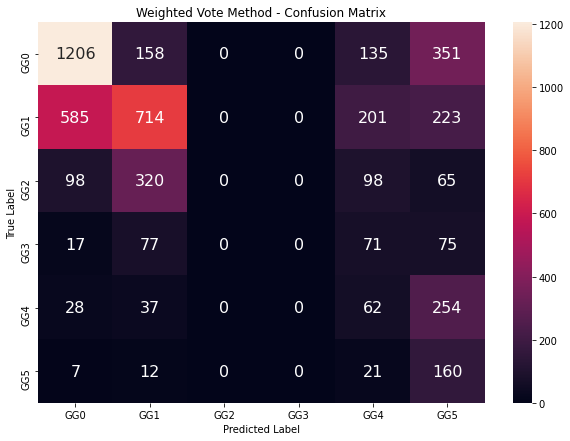

In [13]:
'''
Predict grade group using weighted vote in real way
'''
threshold = 0
threshold_benign = 0.05
threshold_equal_num = 0.7
yhat = []
ytest = []
for case_idx in trange(len(y)):
# for case_idx in trange(10, 11):
    temp1 = []
    for i in DT_data[case_idx]:
        if i == 1:
            temp1.append([1, 0, 0, 0, 0])
        elif i == 2:
            temp1.append([0, 1, 0, 0, 0])
        elif i == 3:
            temp1.append([0, 0, 1, 0, 0])
        elif i == 4:
            temp1.append([0, 0, 0, 1, 0])
        elif i == 5:
            temp1.append([0, 0, 0, 0, 1])
    temp1 = np.stack(temp1)

    temp11 = []
    for idx in range(len(temp1)):
        temp11.append((temp1[idx] * DT_magnitude[case_idx][idx]).tolist())
    temp11 = np.stack(temp11)

    temp111 = np.array([temp11[:, 0][temp11[:, 0] > threshold].sum(), temp11[:, 1][temp11[:, 1] > threshold].sum(), temp11[:, 2][temp11[:, 2] > threshold].sum(), temp11[:, 3][temp11[:, 3] > threshold].sum(), temp11[:, 4][temp11[:, 4] > threshold].sum()])
    temp111 = temp111 / temp111.sum()
    
    if (temp111[2:5].sum() / temp111[0:2].sum()) <= threshold_benign:
        yhat.append(0)
    elif (np.sum(temp111[2:5]) - np.max(temp111[2:5])) / np.max(temp111[2:5]) < threshold_equal_num:
        if (np.argsort(-temp111[2:5])[0] + 3) == 3:
            yhat.append(1)
        elif (np.argsort(-temp111[2:5])[0] + 3) == 4:
            yhat.append(4)
        else:
            yhat.append(5)
    elif (np.argsort(-temp111[2:5])[0] + 3) == 3 and (np.argsort(-temp111[2:5])[1] + 3) == 4:
        yhat.append(2)
    elif (np.argsort(-temp111[2:5])[0] + 3) == 4 and (np.argsort(-temp111[2:5])[1] + 3) == 3:
        yhat.append(3)
    elif (np.argsort(-temp111[2:5])[0] + 3) == 3 and (np.argsort(-temp111[2:5])[1] + 3) == 5:
        yhat.append(4)
    elif (np.argsort(-temp111[2:5])[0] + 3) == 5 and (np.argsort(-temp111[2:5])[1] + 3) == 3:
        yhat.append(4)
    else:
        yhat.append(5)
    
    if y[case_idx] == "0+0":
        ytest.append(0)
    elif int(y[case_idx][0]) == 3 and int(y[case_idx][2]) == 3:
        ytest.append(1)
    elif int(y[case_idx][0]) == 3 and int(y[case_idx][2]) == 4:
        ytest.append(2)
    elif int(y[case_idx][0]) == 4 and int(y[case_idx][2]) == 3:
        ytest.append(3)
    elif int(y[case_idx][0]) == 4 and int(y[case_idx][2]) == 4:
        ytest.append(4)
    elif int(y[case_idx][0]) == 3 and int(y[case_idx][2]) == 5:
        ytest.append(4)
    elif int(y[case_idx][0]) == 5 and int(y[case_idx][2]) == 3:
        ytest.append(4)
    else:
        ytest.append(5)
            
print(confusion_matrix(ytest, yhat))
print((np.array(ytest) == np.array(yhat)).sum() / len(ytest))
print(quadratic_kappa(ytest, yhat, 6))

plt.figure(figsize=(10, 7))
plt.title("Weighted Vote Method - Confusion Matrix")
ax = sn.heatmap(confusion_matrix(ytest, yhat),
                fmt="d",
                annot=True,
                annot_kws={"size":16})
ax.set_xticklabels(["GG0", "GG1", "GG2", "GG3", "GG4", "GG5"])
ax.set_yticklabels(["GG0", "GG1", "GG2", "GG3", "GG4", "GG5"])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

In [56]:
'''
Predict first number using weighted vote in real way
'''
threshold = 0
threshold_benign = 0.01
yhat = []
ytest = []
for case_idx in trange(len(y)):
# for case_idx in trange(10, 30):
    temp1 = []
    for i in DT_data[case_idx]:
        if i == 1:
            temp1.append([1, 0, 0, 0, 0])
        elif i == 2:
            temp1.append([0, 1, 0, 0, 0])
        elif i == 3:
            temp1.append([0, 0, 1, 0, 0])
        elif i == 4:
            temp1.append([0, 0, 0, 1, 0])
        elif i == 5:
            temp1.append([0, 0, 0, 0, 1])
    temp1 = np.stack(temp1)

    temp11 = []
    for idx in range(len(temp1)):
        temp11.append((temp1[idx] * DT_magnitude[case_idx][idx]).tolist())
    temp11 = np.stack(temp11)

    temp111 = np.array([temp11[:, 0][temp11[:, 0] > threshold].sum(), temp11[:, 1][temp11[:, 1] > threshold].sum(), temp11[:, 2][temp11[:, 2] > threshold].sum(), temp11[:, 3][temp11[:, 3] > threshold].sum(), temp11[:, 4][temp11[:, 4] > threshold].sum()])
    temp111 = temp111 / temp111.sum()
    
    if (temp111[2:5].sum() / temp111[0:2].sum()) <= threshold_benign:
        yhat.append(0)
    elif (np.argsort(-temp111[2:5])[0] + 3) == 3:
        yhat.append(1)
    elif (np.argsort(-temp111[2:5])[0] + 3) == 4:
        yhat.append(2)
    else:
        yhat.append(3)
    
    if y[case_idx] == "negative":
        ytest.append(0)
    elif int(y[case_idx][0]) == 3:
        ytest.append(1)
    elif int(y[case_idx][0]) == 4:
        ytest.append(2)
    else:
        ytest.append(3)
            
print(confusion_matrix(ytest, yhat))
print((np.array(ytest) == np.array(yhat)).sum() / len(ytest))
print(quadratic_kappa(ytest, yhat, 4))

  0%|          | 0/1262 [00:00<?, ?it/s]

[[211  31  37   2]
 [ 31 299  50   1]
 [ 22  46 412  38]
 [  8   4  31  39]]
0.7614896988906498
0.7110965153044224


In [22]:
'''
Predict grade group using counting method in real way
'''
x_test = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=range(0, 10))
y_test = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=10, dtype=None, encoding=None)

yhat = []
ytest = []
threshold_benign = 0.015
threshold_equal_num = 0.2
for case_idx in trange(len(y_test)):
    if (x_test[case_idx][2:5].sum() / x_test[case_idx][0:2].sum()) <= threshold_benign:
        yhat.append(0)
    elif (x_test[case_idx][2:5].sum() - np.max(x_test[case_idx][2:5])) / np.max(x_test[case_idx][2:5]) < threshold_equal_num:
        if (np.argsort(-x_test[case_idx][2:5])[0] + 3) == 3:
            yhat.append(1)
        elif (np.argsort(-x_test[case_idx][2:5])[0] + 3) == 4:
            yhat.append(4)
        else:
            yhat.append(5)
    elif (np.argsort(-x_test[case_idx][2:5])[0] + 3) == 3 and (np.argsort(-x_test[case_idx][2:5])[1] + 3) == 4:
        yhat.append(2)
    elif (np.argsort(-x_test[case_idx][2:5])[0] + 3) == 4 and (np.argsort(-x_test[case_idx][2:5])[1] + 3) == 3:
        yhat.append(3)
    elif (np.argsort(-x_test[case_idx][2:5])[0] + 3) == 3 and (np.argsort(-x_test[case_idx][2:5])[1] + 3) == 5:
        yhat.append(4)
    elif (np.argsort(-x_test[case_idx][2:5])[0] + 3) == 5 and (np.argsort(-x_test[case_idx][2:5])[1] + 3) == 3:
        yhat.append(4)
    else:
        yhat.append(5)
    
    if y_test[case_idx] == "negative":
        ytest.append(0)
    elif int(y_test[case_idx][0]) == 3 and int(y_test[case_idx][2]) == 3:
        ytest.append(1)
    elif int(y_test[case_idx][0]) == 3 and int(y_test[case_idx][2]) == 4:
        ytest.append(2)
    elif int(y_test[case_idx][0]) == 4 and int(y_test[case_idx][2]) == 3:
        ytest.append(3)
    elif int(y_test[case_idx][0]) == 4 and int(y_test[case_idx][2]) == 4:
        ytest.append(4)
    elif int(y_test[case_idx][0]) == 3 and int(y_test[case_idx][2]) == 5:
        ytest.append(4)
    elif int(y_test[case_idx][0]) == 5 and int(y_test[case_idx][2]) == 3:
        ytest.append(4)
    else:
        ytest.append(5)

print(confusion_matrix(ytest, yhat))

  0%|          | 0/1262 [00:00<?, ?it/s]

[[226  10  12   6   8  19]
 [ 32 112  44  16   3   4]
 [  6  67  65  21   4   1]
 [ 10   3  29  88  21  42]
 [ 14   3  20  36  55  58]
 [ 15   1   7  36  31 137]]


Epoch 1/200
74/74 [==============================] - 1s 10ms/step - loss: 0.9422 - accuracy: 0.4669 - auc: 0.4254 - val_loss: 0.8890 - val_accuracy: 0.4856 - val_auc: 0.4384
Epoch 2/200
74/74 [==============================] - 0s 6ms/step - loss: 0.8387 - accuracy: 0.5121 - auc: 0.4839 - val_loss: 0.8151 - val_accuracy: 0.5195 - val_auc: 0.4895
Epoch 3/200
74/74 [==============================] - 0s 6ms/step - loss: 0.7880 - accuracy: 0.5322 - auc: 0.5180 - val_loss: 0.7538 - val_accuracy: 0.5535 - val_auc: 0.5472
Epoch 4/200
74/74 [==============================] - 0s 6ms/step - loss: 0.7246 - accuracy: 0.5771 - auc: 0.5786 - val_loss: 0.7022 - val_accuracy: 0.6129 - val_auc: 0.6073
Epoch 5/200
74/74 [==============================] - 0s 6ms/step - loss: 0.6828 - accuracy: 0.6133 - auc: 0.6295 - val_loss: 0.6598 - val_accuracy: 0.6655 - val_auc: 0.6672
Epoch 6/200
74/74 [==============================] - 0s 6ms/step - loss: 0.6426 - accuracy: 0.6662 - auc: 0.6927 - val_loss: 0.6232 - 

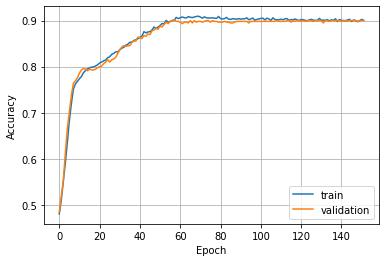

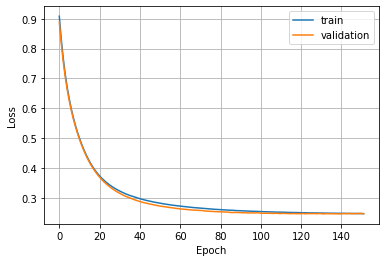

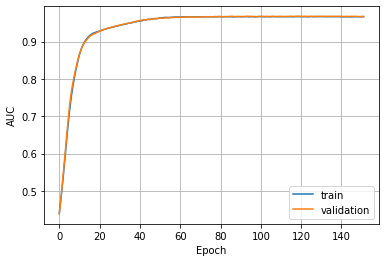

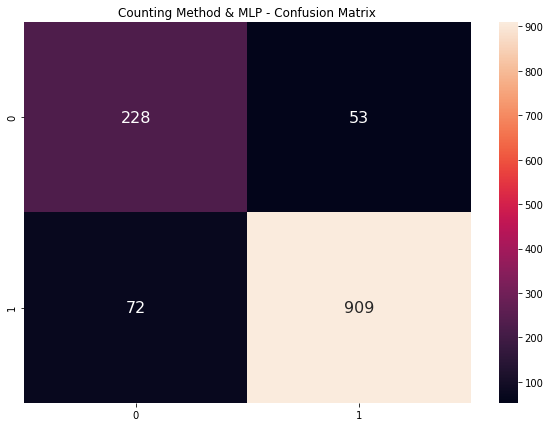

In [9]:
"""
Predict grade group using counting method + MLP in real way
"""
x_train = np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=range(5, 10))
# x_train1 = np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification1.csv", delimiter=",", usecols=range(20))
# x_train2 = np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification2.csv", delimiter=",", usecols=range(20))
y_train = np.genfromtxt("./prostate-cancer-grade-assessment/train_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=10, dtype=None, encoding=None)
x_validation = np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=range(5, 10))
# x_validation1 = np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification1.csv", delimiter=",", usecols=range(20))
# x_validation2 = np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification2.csv", delimiter=",", usecols=range(20))
y_validation = np.genfromtxt("./prostate-cancer-grade-assessment/validation_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=10, dtype=None, encoding=None)
x_test = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=range(5, 10))
# x_test1 = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification1.csv", delimiter=",", usecols=range(20))
# x_test2 = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification2.csv", delimiter=",", usecols=range(20))
y_test = np.genfromtxt("./prostate-cancer-grade-assessment/test_slideFolders_classification2_threshold_0.csv", delimiter=",", usecols=10, dtype=None, encoding=None)

# x_train = np.concatenate((x_train, x_train1), axis=1)
# x_validation = np.concatenate((x_validation, x_validation1), axis=1)
# x_test = np.concatenate((x_test, x_test1), axis=1)

x_train = x_train.reshape(len(x_train), 5)
y_train = y_train.reshape(len(y_train), 1)
x_validation = x_validation.reshape(len(x_validation), 5)
y_validation = y_validation.reshape(len(y_validation), 1)
x_test = x_test.reshape(len(x_test), 5)
y_test = y_test.reshape(len(y_test), 1)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)

y_train[y_train == "negative"] = 0
y_train[y_train == "3+3"] = 1
y_train[y_train == "3+4"] = 1
y_train[y_train == "4+3"] = 1
y_train[y_train == "4+4"] = 1
y_train[y_train == "3+5"] = 1
y_train[y_train == "5+3"] = 1
y_train[y_train == "4+5"] = 1
y_train[y_train == "5+4"] = 1
y_train[y_train == "5+5"] = 1
y_train = y_train.astype(np.float)

y_validation[y_validation == "negative"] = 0
y_validation[y_validation == "3+3"] = 1
y_validation[y_validation == "3+4"] = 1
y_validation[y_validation == "4+3"] = 1
y_validation[y_validation == "4+4"] = 1
y_validation[y_validation == "3+5"] = 1
y_validation[y_validation == "5+3"] = 1
y_validation[y_validation == "4+5"] = 1
y_validation[y_validation == "5+4"] = 1
y_validation[y_validation == "5+5"] = 1
y_validation = y_validation.astype(np.float)

y_test[y_test == "negative"] = 0
y_test[y_test == "3+3"] = 1
y_test[y_test == "3+4"] = 1
y_test[y_test == "4+3"] = 1
y_test[y_test == "4+4"] = 1
y_test[y_test == "3+5"] = 1
y_test[y_test == "5+3"] = 1
y_test[y_test == "4+5"] = 1
y_test[y_test == "5+4"] = 1
y_test[y_test == "5+5"] = 1
y_test = y_test.astype(np.float)

# y_train[y_train == "negative"] = 0
# y_train[y_train == "3+3"] = 1
# y_train[y_train == "3+4"] = 1
# y_train[y_train == "4+3"] = 2
# y_train[y_train == "4+4"] = 2
# y_train[y_train == "3+5"] = 1
# y_train[y_train == "5+3"] = 3
# y_train[y_train == "4+5"] = 2
# y_train[y_train == "5+4"] = 3
# y_train[y_train == "5+5"] = 3
# y_train = y_train.astype(np.float)

# y_validation[y_validation == "negative"] = 0
# y_validation[y_validation == "3+3"] = 1
# y_validation[y_validation == "3+4"] = 1
# y_validation[y_validation == "4+3"] = 2
# y_validation[y_validation == "4+4"] = 2
# y_validation[y_validation == "3+5"] = 1
# y_validation[y_validation == "5+3"] = 3
# y_validation[y_validation == "4+5"] = 2
# y_validation[y_validation == "5+4"] = 3
# y_validation[y_validation == "5+5"] = 3
# y_validation = y_validation.astype(np.float)

# y_test[y_test == "negative"] = 0
# y_test[y_test == "3+3"] = 1
# y_test[y_test == "3+4"] = 1
# y_test[y_test == "4+3"] = 2
# y_test[y_test == "4+4"] = 2
# y_test[y_test == "3+5"] = 1
# y_test[y_test == "5+3"] = 3
# y_test[y_test == "4+5"] = 2
# y_test[y_test == "5+4"] = 3
# y_test[y_test == "5+5"] = 3
# y_test = y_test.astype(np.float)

# enc = OrdinalEncoder()
# enc.fit(y_train)
# y_train = enc.transform(y_train)
# y_validation = enc.transform(y_validation)
# y_test = enc.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_validation = tf.keras.utils.to_categorical(y_validation, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(5,)),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss="categorical_crossentropy",
    metrics=['accuracy', 'AUC']
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)
history = model.fit(x=x_train, y=y_train, epochs=200, validation_data=(x_validation, y_validation), shuffle=True, callbacks=[es])
model.evaluate(x_test, y_test)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

yhat = model.predict(x_test)
yhat = np.argmax(yhat, axis=1)
y_test = np.argmax(y_test, axis=1)

confMatrix = confusion_matrix(y_test, yhat)
plt.figure(figsize=(10, 7))
plt.title("Counting Method & MLP - Confusion Matrix")
ax = sn.heatmap(confMatrix,
                fmt="d",
                annot=True,
                annot_kws={"size":16})
# ax.set_xticklabels(["GG0", "GG1", "GG2", "GG3", "GG4", "GG5"])
# ax.set_yticklabels(["GG0", "GG1", "GG2", "GG3", "GG4", "GG5"])
# ax.set(ylabel="True Label", xlabel="Predicted Label")
# plt.show()
# print(quadratic_kappa(y_test, yhat, 6))